In [3]:
import pandas as pd

# Load the data from the CSV file
btc_data = pd.read_csv('btc_1d_data_2018_to_2025.csv')

# Ensure the data is sorted by date if not already
btc_data['Open time'] = pd.to_datetime(btc_data['Open time'])
btc_data = btc_data.sort_values(by='Open time')

# Calculate the 4-day and 7-day moving averages
btc_data['4MA'] = btc_data['Close'].rolling(window=4).mean()
btc_data['7MA'] = btc_data['Close'].rolling(window=7).mean()

# Display the updated DataFrame
btc_data.head(10)

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,4MA,7MA
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844,2018-01-01 23:59:59.999,1.147997e+08,105595,3961.938946,5.280975e+07,0,NaN,NaN
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,1.580801e+08,0,NaN,NaN
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,1.335873e+08,0,NaN,NaN
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,1.861168e+08,0,14508.5400,NaN
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,2.118299e+08,0,15403.6375,NaN
5,2018-01-06,16960.39,17143.13,16011.21,17069.79,18571.457508,2018-01-06 23:59:59.999,3.092169e+08,158242,11007.164056,1.834178e+08,0,16002.3075,NaN
6,2018-01-07,17069.79,17099.96,15610.00,16150.03,12493.125558,2018-01-07 23:59:59.999,2.061947e+08,120269,6779.320508,1.121512e+08,0,16309.9375,15459.195714
7,2018-01-08,16218.85,16322.30,12812.00,14902.54,26600.609912,2018-01-08 23:59:59.999,3.965700e+08,208642,13756.844389,2.060496e+08,0,16270.6875,15676.701429
8,2018-01-09,14902.54,15500.00,14011.05,14400.00,14315.004253,2018-01-09 23:59:59.999,2.106302e+08,156656,6841.233287,1.006986e+08,0,15630.5900,15637.400000
9,2018-01-10,14401.00,14955.66,13131.31,14907.09,17411.001655,2018-01-10 23:59:59.999,2.440114e+08,161476,8529.554675,1.195701e+08,0,15089.9150,15635.625714


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define a quadratic function for curve fitting
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Function to check for an upside trend before the cup
def has_upside_trend(prices, idx, lookback=21, min_increase=0.50):
    if idx < lookback:
        return False  # Not enough data for the lookback period
    recent_prices = prices[idx - lookback:idx]
    avg_increase = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
    return avg_increase >= min_increase

# Function to check for a valid cup formation with quadratic verification
def is_valid_cup(prices, tolerance=0.03, min_drop=0.05):
    x = np.arange(len(prices))  # X-axis values (time indices)
    left_edge = prices[0]  # Left edge of the cup
    right_edge = prices[-1]  # Right edge of the cup
    bottom = min(prices)  # Bottom of the cup
    bottom_idx = np.argmin(prices)  # Index of the bottom

    # Ensure the bottom is at least `min_drop` lower than both edges
    if bottom >= left_edge * (1 - min_drop) or bottom >= right_edge * (1 - min_drop):
        return False

    # Ensure the left and right edges are within `tolerance` of each other
    if abs(left_edge - right_edge) / left_edge > tolerance:
        return False

    # Fit a quadratic curve to the prices
    try:
        params, _ = curve_fit(quadratic, x, prices)
        a, b, c = params

        # Check if the curve is a U-shape (a > 0)
        if a <= 0:
            return False

        # Check if the minimum point of the quadratic curve aligns with the bottom
        min_idx = -b / (2 * a)
        if abs(min_idx - bottom_idx) > len(prices) * 0.1:  # Allow a 10% deviation
            return False
    except:
        return False

    return True

# Function to check for a valid handle formation
def is_valid_handle(prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
    handle_start = prices[0]
    handle_end = prices[-1]
    handle_drop = handle_start - handle_end
    required_drop = min_drop_ratio * (cup_height - cup_bottom)

    # Ensure the handle lasts at least `min_days` and drops by the required amount
    if len(prices) < min_days or handle_drop < required_drop:
        return False

    # Ensure the handle is a downtrend
    return all(prices[i] >= prices[i + 1] for i in range(len(prices) - 1))

# Function to check for a breakthrough after the handle
def has_breakthrough(prices, handle_end_idx):
    if handle_end_idx + 1 >= len(prices):
        return False  # Not enough data for breakthrough check
    handle_prices = prices[:handle_end_idx + 1]
    handle_slope = (handle_prices[-1] - handle_prices[0]) / len(handle_prices)

    # Check if the price breaks above the downward slope of the handle
    for i in range(handle_end_idx + 1, len(prices)):
        if prices[i] > handle_prices[-1] + handle_slope * (i - handle_end_idx):
            return True
    return False

btc_data["7MA"] = btc_data["Close"].rolling(window=7).mean()

# Detect cup and handle patterns in the price data
btc_data["Cup_Formation"] = 0
btc_data["Handle_Formation"] = 0
btc_data["Breakthrough"] = 0
btc_data["Cup_Start"] = np.nan
btc_data["Cup_End"] = np.nan
prices = btc_data["4MA"].values

for idx in range(len(btc_data) - 60):  # Ensure enough data for a 30-day window
    for period in range(14, 60):  # Check for periods between 14 and 60 days
        if idx + period < len(btc_data):
            cup_prices = prices[idx:idx + period]
            if has_upside_trend(prices, idx, lookback=7, min_increase=0.10) and is_valid_cup(cup_prices, tolerance=0.03, min_drop=0.05):
                cup_bottom = min(cup_prices)
                cup_height = max(cup_prices[0], cup_prices[-1])
                btc_data.loc[idx + period - 1, "Cup_Formation"] = 1  # Mark the rightmost position of the cup
                btc_data.loc[idx, "Cup_Start"] = 1  # Mark the starting point of the cup
                btc_data.loc[idx + period - 1, "Cup_End"] = 1  # Mark the ending point of the cup

                # Check for handle formation
                handle_start_idx = idx + period
                for handle_period in range(7, 15):  # Check for handle periods between 7 and 15 days
                    if handle_start_idx + handle_period < len(btc_data):
                        handle_prices = prices[handle_start_idx:handle_start_idx + handle_period]
                        if is_valid_handle(handle_prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
                            btc_data.loc[handle_start_idx + handle_period - 1, "Handle_Formation"] = 1

                            # Check and mark for breakthrough
                            if has_breakthrough(prices, handle_start_idx + handle_period - 1):
                                btc_data.loc[handle_start_idx + handle_period - 1, "Breakthrough"] = 1
                            break

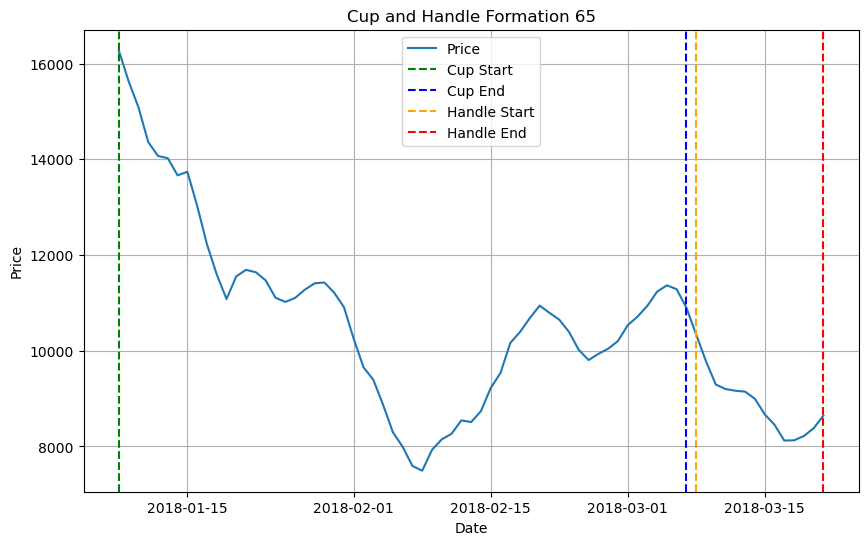

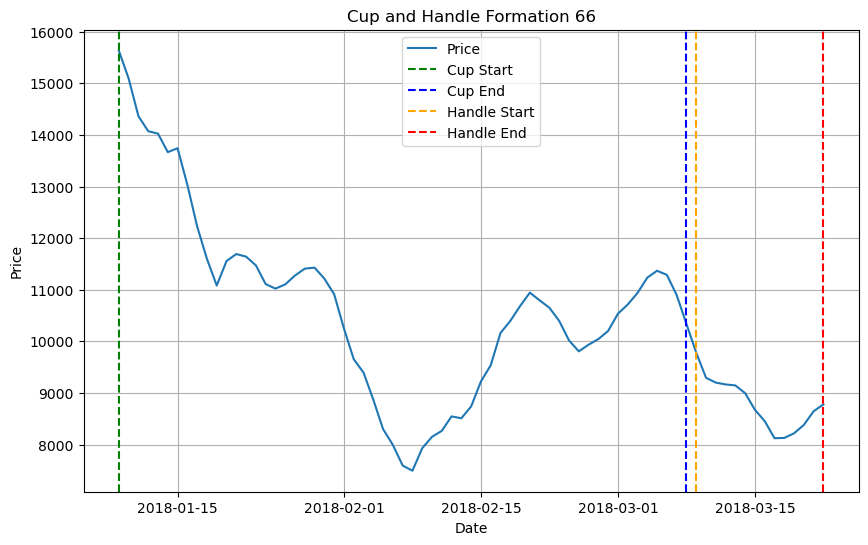

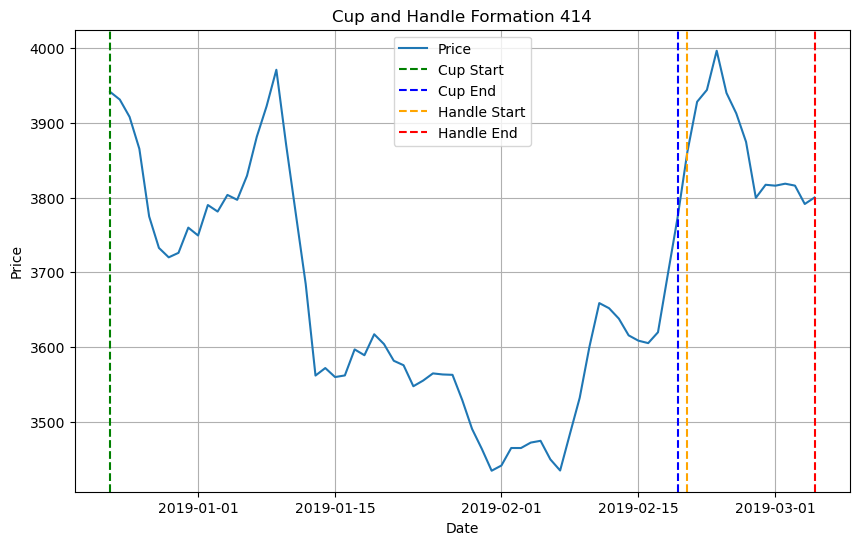

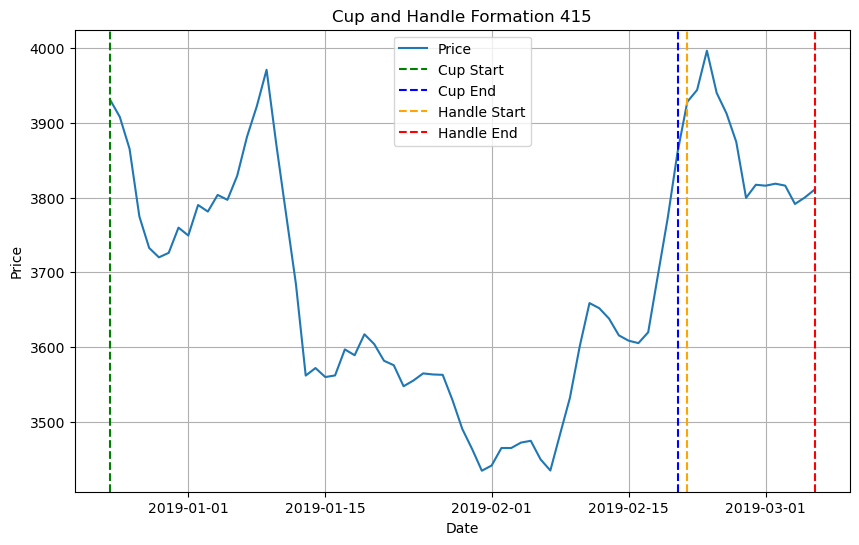

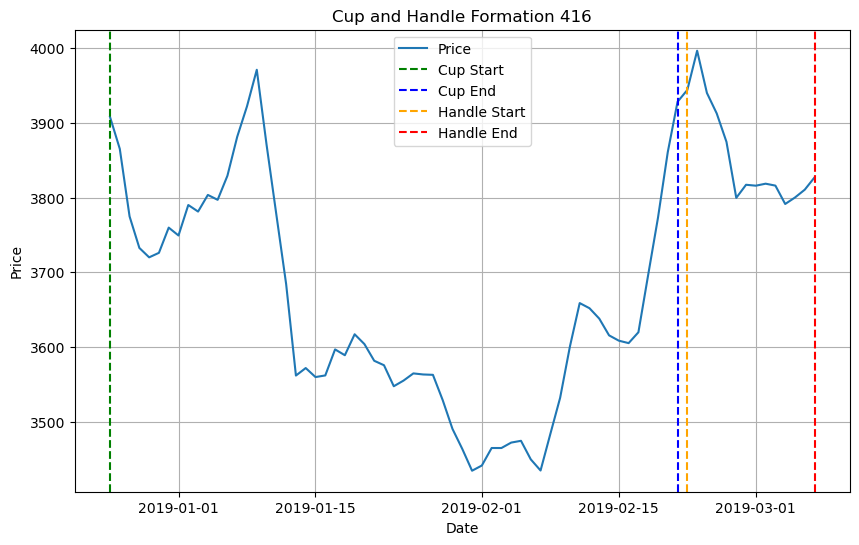

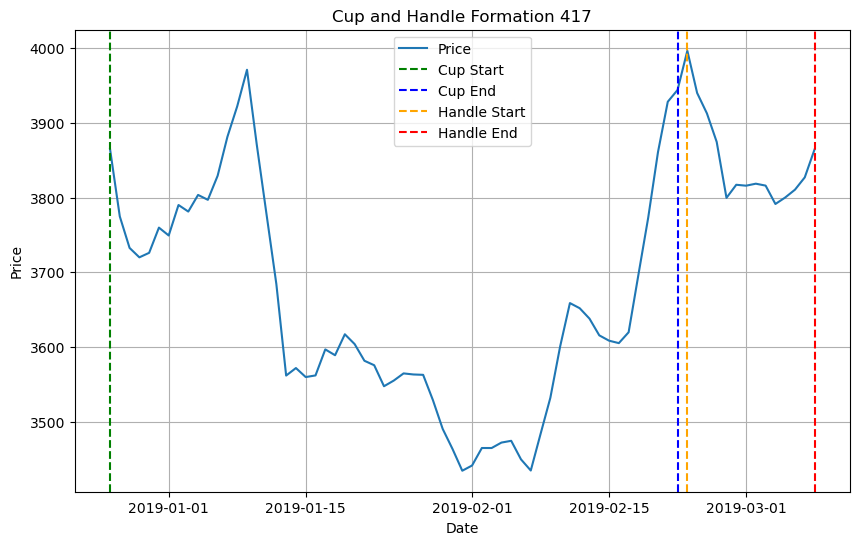

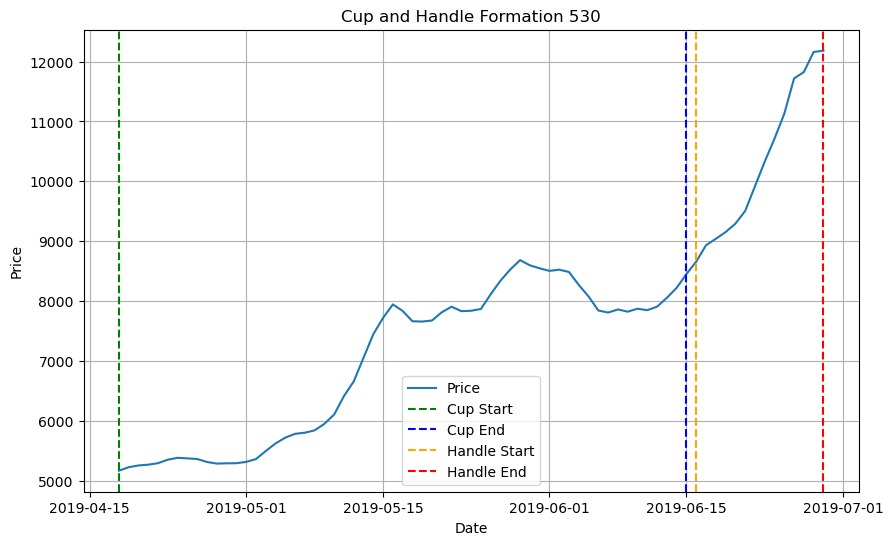

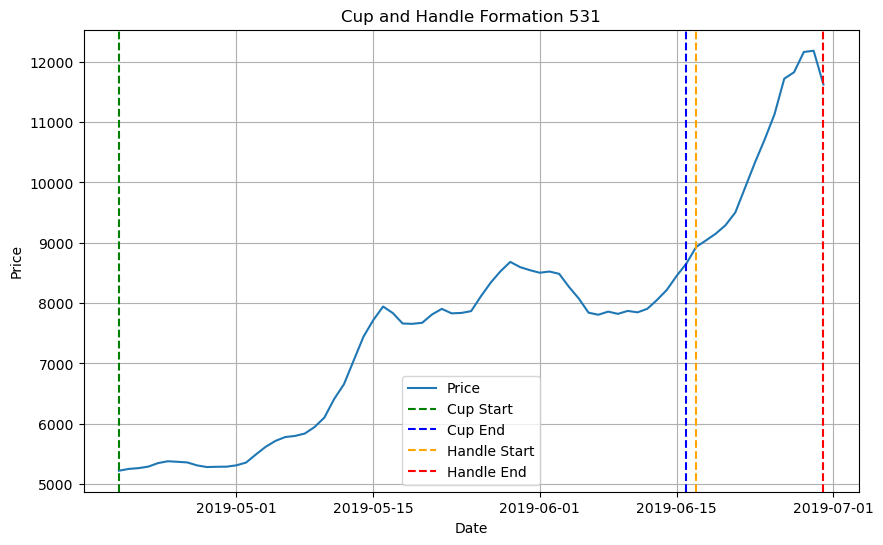

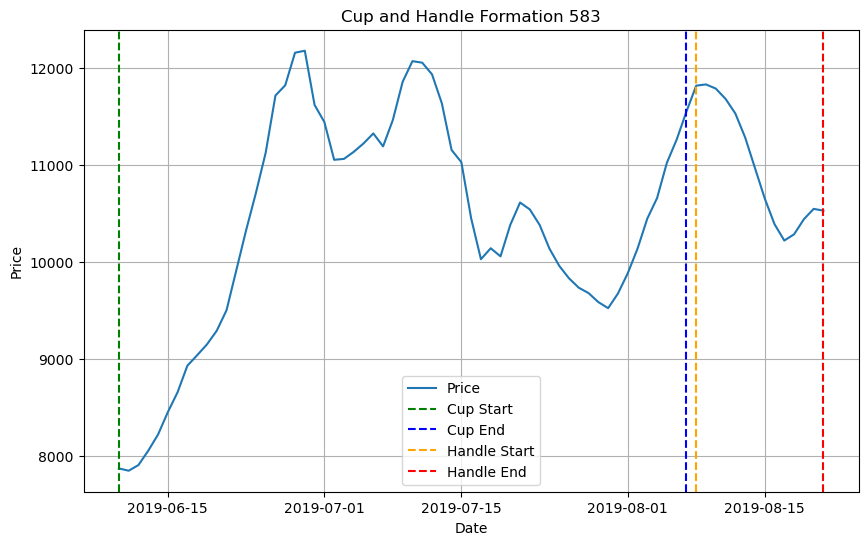

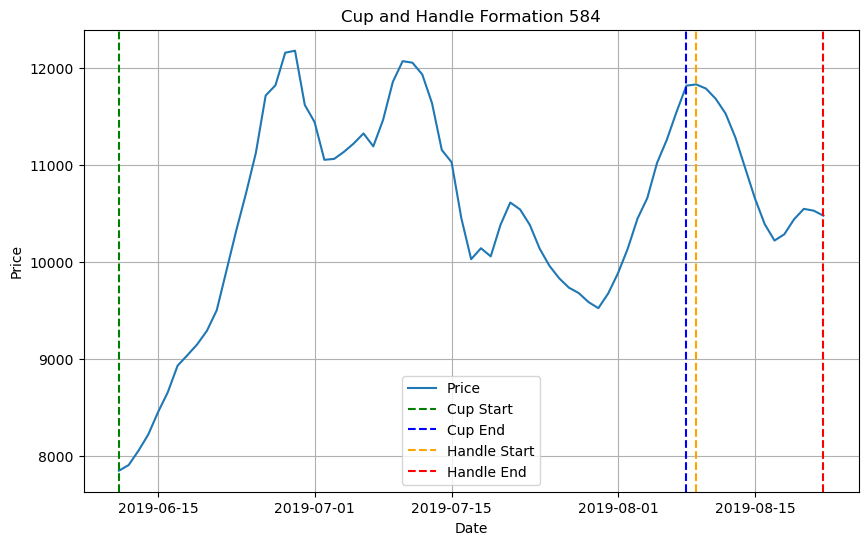

In [7]:
# Plot the first 5 cup and handle formations
import matplotlib.pyplot as plt

# Filter the rows where a cup formation is detected
cup_indices = btc_data[btc_data["Cup_Formation"] == 1].index[:10]

# Plot the first 5 cup and handle formations
for idx in cup_indices:
    start_idx = idx - period + 1  # Start of the cup
    end_idx = idx  # End of the cup
    handle_start_idx = idx + 1  # Start of the handle
    handle_end_idx = handle_start_idx + handle_period - 1  # End of the handle

    plt.figure(figsize=(10, 6))
    plt.plot(btc_data["Open time"][start_idx:handle_end_idx + 1], prices[start_idx:handle_end_idx + 1], label="Price")
    plt.axvline(btc_data["Open time"][start_idx], color="green", linestyle="--", label="Cup Start")
    plt.axvline(btc_data["Open time"][end_idx], color="blue", linestyle="--", label="Cup End")
    plt.axvline(btc_data["Open time"][handle_start_idx], color="orange", linestyle="--", label="Handle Start")
    plt.axvline(btc_data["Open time"][handle_end_idx], color="red", linestyle="--", label="Handle End")
    plt.title(f"Cup and Handle Formation {idx}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()